In [ ]:
# pip install arro3-core
# pip install tabulate

In [211]:
import os
import json
import yaml
import logging
import zarr
import s3fs
import fsspec
import numcodecs
import geojson
import pystac
import pyproj
import xarray
import rioxarray
import pandas as pd
import pyarrow as pa
import geopandas as gpd
import numpy as np
import xarray as xr
import obstore as obs
import matplotlib.pyplot as plt
import shapely.geometry
import odc.geo.xr

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from datetime import datetime
from IPython.display import HTML, display, Image
from copy import deepcopy
from tqdm.auto import tqdm

from odc.stac import stac_load
from odc.stac import configure_rio, stac_load
from odc.geo.geobox import GeoBox
from odc.geo.geom import Geometry

from satstac import Catalog, Collection, Item
from shapely.geometry import shape, Polygon, LinearRing
from shapely.ops import transform
from pystac_client import Client
from pystac.extensions.projection import ProjectionExtension
from geojson.utils import coords
from pyproj import CRS, Transformer
from numcodecs import Blosc
from zarr.codecs.blosc import BloscCodec
from zarr.storage import ObjectStore
from obstore.store import S3Store, MemoryStore, from_url
from s3fs import S3Map

In [33]:
def bounds_to_ring(geom):
    minx, miny, maxx, maxy = geom.bounds
    return LinearRing([
        (minx, miny),
        (maxx, miny),
        (maxx, maxy),
        (minx, maxy),
        (minx, miny)
    ])


def load_geosjon(path: str) -> dict:
    with open(path, "r") as f:
        obj = geojson.load(f)
    return obj


def get_polygon_from_geometry(geometry: dict) -> Polygon:
    return Polygon(coords(geometry['coordinates']))

# Carregando dados

## Grade Sentinel-2

In [94]:
gdf = gpd.read_file("data/grade_sentinel/shapefile/grade_sentinel_brasil.shp")

In [95]:
gdf.head(3)

,NAME,LAYER,_font_COLO,_font_COL1,_font_COL2,_font_COL3,_font_COL4,KML_FOLDER,CLOSED,BORDER_STY,FILL_STYLE,FILL_COLOR,LABEL_POS,FONT_SIZE,FONT_COLOR,FONT_CHARS,geometry
0,18LXQ,Unknown Area Type,"<font COLOR=""#008000"">18LXQ</font>","<font COLOR=""#008000"">32718</font>","<font COLOR=""#008000"">-9.0454332618 -74.090120...","<font COLOR=""#008000"">MULTIPOLYGON(((600000 90...","<font COLOR=""#008000"">MULTIPOLYGON(((-74.09012...",Features,YES,Null,Solid Fill,"RGB(255,0,0)","-73.5886935802,-9.5396490869",12,"RGB(0,0,0)",0,"POLYGON ((-74.09012 -9.04507, -73.09136 -9.041..."
1,18LXR,Unknown Area Type,"<font COLOR=""#008000"">18LXR</font>","<font COLOR=""#008000"">32718</font>","<font COLOR=""#008000"">-8.1410194048 -74.092274...","<font COLOR=""#008000"">MULTIPOLYGON(((600000 91...","<font COLOR=""#008000"">MULTIPOLYGON(((-74.09227...",Features,YES,Null,Solid Fill,"RGB(255,0,0)","-73.5922286097,-8.6358163494",12,"RGB(0,0,0)",0,"POLYGON ((-74.09227 -8.14102, -73.09587 -8.137..."
2,18LYP,Unknown Area Type,"<font COLOR=""#008000"">18LYP</font>","<font COLOR=""#008000"">32718</font>","<font COLOR=""#008000"">-9.9460709594 -73.175699...","<font COLOR=""#008000"">MULTIPOLYGON(((699960 89...","<font COLOR=""#008000"">MULTIPOLYGON(((-73.17606...",Features,YES,Null,Solid Fill,"RGB(255,0,0)","-72.6719424324,-10.4386946623",12,"RGB(0,0,0)",0,"POLYGON ((-73.17607 -9.94589, -72.17522 -9.938..."


In [96]:
gdf_grade = gdf[['NAME', 'geometry']]
gdf_grade = gdf_grade.rename(columns={"NAME": "tile_name"})

In [97]:
crs = "EPSG:4674"
gdf_grade = gdf_grade.to_crs(crs)

In [98]:
# gdf_grade = gdf_grade.rename_geometry('geometry_tile')

In [99]:
gdf_grade.head(3)

,tile_name,geometry
0,18LXQ,"POLYGON ((-74.09012 -9.04507, -73.09136 -9.041..."
1,18LXR,"POLYGON ((-74.09227 -8.14102, -73.09587 -8.137..."
2,18LYP,"POLYGON ((-73.17607 -9.94589, -72.17522 -9.938..."


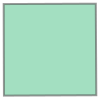

In [101]:
gdf_grade[gdf_grade['tile_name'] == '18LXQ'].geometry[0]

## Municipios

In [102]:
gdf_municipios = gpd.read_file('data/municipio/BR_Municipios_2020.shp')

In [103]:
gdf_municipios.head(5)

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8..."
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-62.53648 -9.73222, -62.52765 -9.736..."
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.37119 -13.36655, -60.37134 -13.3..."
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.0008 -11.29737, -61.00103 -11.39..."
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-61.49976 -13.00525, -61.49809 -13.0..."


In [104]:
crs = "EPSG:4674"
gdf_municipios = gdf_municipios.to_crs(crs)

## Juntando dataframes

In [129]:
gdf_joined = gpd.sjoin(gdf_municipios, gdf_grade, how="left", predicate="overlaps", rsuffix="tile")

In [130]:
gdf_joined.head()

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,index_tile,tile_name
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8...",147.0,20LNL
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8...",154.0,20LPL
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8...",148.0,20LNM
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8...",155.0,20LPM
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8...",149.0,20LNN


In [131]:
gdf_joined = gdf_joined.drop(columns=['index_tile'])

In [132]:
gdf_joined['boundary'] = gdf_joined.boundary
gdf_joined["centroid"] = gdf_joined.centroid
gdf_joined["bounds"] = gdf_joined.geometry.apply(bounds_to_ring)

/tmp/ipykernel_307/543301058.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_joined["centroid"] = gdf_joined.centroid


In [133]:
# gdf_mg["bounds_buffer"] = gdf_mg["bounds_buffer"].buffer(0.05)

In [143]:
gdf_joined.value_counts('tile_name')

tile_name
22JCQ    41
24MZT    39
23KLR    39
22JBQ    39
23KQT    38
         ..
18MYV     1
18MYU     1
18LXQ     1
26KKC     1
26KLC     1
Name: count, Length: 1020, dtype: int64

In [147]:
TILE = "23KQT"

gdf_23kqt = gdf_joined[gdf_joined['tile_name'] == TILE]
gdf_tile = gdf_grade[gdf_grade['tile_name'] == TILE]

In [135]:
gdf_mg = gdf_joined[gdf_joined['SIGLA_UF'] == 'MG']
gdf_lafaiete = gdf_mg[gdf_mg['NM_MUN'] == 'Conselheiro Lafaiete'].reset_index()

In [136]:
gdf_lafaiete.head(5)

,index,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,tile_name,boundary,centroid,bounds
0,2445,3118304,Conselheiro Lafaiete,MG,370.246,"POLYGON ((-43.79878 -20.53897, -43.79853 -20.5...",23KPS,"LINESTRING (-43.79878 -20.53897, -43.79853 -20...",POINT (-43.78866 -20.66601),"LINEARRING (-43.93001 -20.80102, -43.67878 -20..."


### Gerar poligono

In [190]:
geom_tile = json.loads(gdf_tile['geometry'].to_json())['features'][0]['geometry']
# geom

In [191]:
def generate_polygon(geom):
    polygon = get_polygon_from_geometry(geom)
    transformer = Transformer.from_crs("urn:ogc:def:crs:OGC:1.3:CRS84", "EPSG:4326", always_xy=True)
    polygon = transform(transformer.transform, polygon)
    return polygon

def print_doundares(polygon):
    min_lon, min_lat, max_lon, max_lat = polygon.bounds
    print(f"Latitude:  {min_lat} : {max_lat}")
    print(f"Longitude: {min_lon} : {max_lon}")

In [192]:
polygon_tile = generate_polygon(geom_tile)

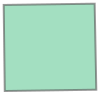

In [193]:
polygon_tile

In [195]:
# print_doundares(polygon_tile)

Latitude:  -20.8772655529 : -19.8713100315
Longitude: -43.0900815406 : -42.0232303486


## Buscando imagens

In [153]:
CATALOG = "https://earth-search.aws.element84.com/v1/"
client = Client.open(CATALOG)

In [230]:
%%time

start_date = datetime(2025, 3, 1).strftime("%Y-%m-%d")
end_date = datetime(2025, 3, 30).strftime("%Y-%m-%d")

search = client.search(
    collections=["sentinel-2-l2a"],
    # query={"sentinel:tileId": {"eq": "23KQT"}},
    # query={"s2:tile_id": {"eq": "23KQT"}},
    datetime=f"{start_date}/{end_date}",
    bbox=polygon_tile.bounds,
    # sortby=[{"field": "properties.datetime", "direction": "asc"}],
)

items = list(search.items())
print(f"Found: {len(items):d} datasets")

Found: 53 datasets
CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 1.74 s


In [241]:
print(type(search))

<class 'pystac_client.item_search.ItemSearch'>


In [231]:
# collections = search.item_collection()
# collections

In [232]:
# Image(collections[1].assets['thumbnail'].href)

In [183]:
items_tile = [
    item for item in items
    if item.properties.get("grid:code", "").split("-")[-1] == "23KQT"
]

print(f"Retorned: {len(items_tile):d} items")

Retorned: 6 items


In [240]:
print(type(items_tile[0]))
print()
items_tile[0]

<class 'pystac.item.Item'>



<Item id=S2C_23KQT_20250328_0_L2A>

In [223]:
IDX = 3
gdf_analysis = gdf_23kqt[:IDX]
geom_analysis = json.loads(gdf_analysis['geometry'].to_json())['features'][0]['geometry']
polygon_analysis = generate_polygon(geom_analysis)

In [234]:
%%time
# https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html
crs = "epsg:3395" # EPSG:32723 | 4326 | 3857 | 3395 | 4674 | ESRI:54009

dataset = stac_load(
    items_tile,
    bands=("red", "green", "blue", "nir", "nir08", "rededge1", "rededge2", "rededge3", "swir16", "swir22", "scl"),
    crs=crs,
    resolution=10,
    groupby="solar_day",
    bbox=polygon_analysis.bounds,
    # dtype="float32",
    # nodata=0,
    # query={"eo:cloud_cover": {"lt": 20}},
    progress=tqdm,
    # chunks={"x": 2048, "y": 2048},  # <-- use Dask
    pool=os.cpu_count(),
)

  0%|          | 0/66 [00:00<?, ?it/s]

CPU times: user 5.69 s, sys: 389 ms, total: 6.08 s
Wall time: 5.54 s


In [225]:
# display(dataset)

In [226]:
# dataset.odc.geobox

In [227]:
compressor = BloscCodec(cname="lz4", clevel=5, shuffle="shuffle")

encoding = {
    var: {
        # "shape": ds_shape,
        "compressor": compressor,
        "shards": (1, 4096, 4096),
        "chunks": (1, 2048, 2048),  # (time, y, x),
    }
    for var in dataset.data_vars
}

In [228]:
s3_store = S3Store(
    bucket="data-us-east-1-891377318910",
    prefix=f"geospatial/starage/zarr_tile/idx_{IDX:02}.zarr"
)
zarr_store = ObjectStore(s3_store)

In [229]:
%%time
# https://github.com/maxrjones/zarr-obstore-performance/tree/main

prefix_name = "zarr"

# 4. Write to a consolidated Zarr store on S3 with optimal settings
dataset.to_zarr(
    # store=f"{S3_PREFIX}/{prefix_name}/lafaiete2.zarr",
    store=zarr_store,
    mode="w",
    consolidated=True,
    encoding=encoding,
    write_empty_chunks=False,
    zarr_format=3,
)

CPU times: user 2.16 s, sys: 293 ms, total: 2.46 s
Wall time: 4.34 s


## satstac

In [ ]:
# https://github.com/sat-utils/sat-stac/blob/master/tutorial-2.ipynb

In [43]:
cat = Catalog.open('https://sentinel-stac.s3.amazonaws.com/catalog.json')
print(cat, cat.filename)

sentinel-stac https://sentinel-stac.s3.amazonaws.com/catalog.json


In [52]:
col = Collection.open('https://sentinel-stac.s3.amazonaws.com/sentinel-2-l1c/catalog.json')
print(col, col.filename)

sentinel-2-l1c https://sentinel-stac.s3.amazonaws.com/sentinel-2-l1c/catalog.json


In [50]:
print('Title:', col.title)
print('Collection Version:', col.version)
print('Keywords: ', col.keywords)
print('License:', col.license)
print('Providers:', col.providers)
print('Extent', col.extent)

Title: Sentinel 2 L1C
Collection Version: 0.1.0
Keywords:  ['sentinel', 'earth observation', 'esa']
License: proprietary
Providers: [{'name': 'ESA', 'roles': ['producer'], 'url': 'https://earth.esa.int/web/guest/home'}, {'name': 'Synergise', 'roles': ['processor'], 'url': 'https://registry.opendata.aws/sentinel-2/'}, {'name': 'AWS', 'roles': ['host'], 'url': 'http://sentinel-pds.s3-website.eu-central-1.amazonaws.com/'}, {'name': 'Development Seed', 'roles': ['processor'], 'url': 'https://github.com/sat-utils/sat-stac-sentinel'}]
Extent {'spatial': [-180, -90, 180, 90], 'temporal': ['2013-06-01', None]}


In [48]:
item = Item.open('https://sentinel-stac.s3.amazonaws.com/sentinel-2-l1c/59/catalog.json')
print(item, item.filename)

59 https://sentinel-stac.s3.amazonaws.com/sentinel-2-l1c/59/catalog.json


## obstore

In [ ]:
# https://developmentseed.org/obstore/latest/api/store/aws/
# https://developmentseed.org/obstore/latest/examples/zarr/

In [116]:
store = S3Store(bucket="sentinel-cogs", prefix="sentinel-s2-l2a-cogs/60/C/VA/2025/2", region="us-west-2", skip_signature=True)

stream = obs.list(store, chunk_size=100, return_arrow=True)

In [117]:
for record_batch in stream:
    # Convert to pyarrow (zero-copy), then to pandas for easy export to a
    # Markdown table
    df = pa.record_batch(record_batch).to_pandas()
    print(df.iloc[:5].to_markdown(index=False))
    break

| path                             | last_modified             |      size | e_tag                                 | version   |
|:---------------------------------|:--------------------------|----------:|:--------------------------------------|:----------|
| S2B_60CVA_20250201_0_L2A/AOT.tif | 2025-02-01 23:45:11+00:00 |     78674 | "2a6b38c9aff640b294f276cceb715c3c"    |           |
| S2B_60CVA_20250201_0_L2A/B01.tif | 2025-02-01 23:38:10+00:00 |   6354168 | "822d8ef2c0a2ff1f9d128f158d51a55b"    |           |
| S2B_60CVA_20250201_0_L2A/B02.tif | 2025-02-01 23:39:20+00:00 | 208999443 | "405582eac2944e00e05b4d823806f767-25" |           |
| S2B_60CVA_20250201_0_L2A/B03.tif | 2025-02-01 23:40:34+00:00 | 207876040 | "cd4dc9b29033270e27cafcc8dbcafc13-25" |           |
| S2B_60CVA_20250201_0_L2A/B04.tif | 2025-02-01 23:41:49+00:00 | 204214039 | "72286eea4bde0ddc5bfc1fda706394d9-25" |           |
